In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import keras
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LambdaCallback, CSVLogger

from keras_tqdm import TQDMNotebookCallback


import io

def load_vectors(fname, words):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin, total=1000000):
        tokens = line.rstrip().split(' ')
        if tokens[0] in words:
            data[tokens[0]] = list(map(float, tokens[1:]))
    return data

pd.set_option('max_colwidth', 800)

Using TensorFlow backend.


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

from preprocess import preprocess_sentence, _preprocess

In [6]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    plt.grid(False)
    return plt.gcf()


In [7]:
def savefig(fig, name):
    if not os.path.exists("results"):
        os.mkdir("results")
    
    fig_path = os.path.join("results", name)
    print('saving figure to %s' %fig_path)
    fig.savefig(fig_path, bbox_inches='tight')
    

In [8]:
path_to_fast_text_vec = input()
print(path_to_fast_text_vec)

D:\data\fasttext\wiki-news-300d-1M.vec
D:\data\fasttext\wiki-news-300d-1M.vec


In [9]:
data = pd.read_csv("08_new_df.pd",index_col="Unnamed: 0")

In [11]:
data.sample(10)

,text,category
2916,"The White House hyped up a 'Pittsburgh, not Paris' rally — and Trump skipped it to go to his golf club",politics
1094,"So, I recently found out I was gay, but I didn't want to tell anyone, but the other day, I just said fuck it and told the whole school, and it turned out, no one thought of me as any different. I actually asked out a boy yesterday - and he said yes!!! But I still haven't told my parents.",lgbt
7123,"A growing group of women concerned about climate change are choosing not to reproduce. Called BirthStrikers, they agree to not bear children “due to the severity of the ecological crisis and the current inaction of governing forces in the face of this existential threat.”",environment
5841,"This needs to be more widely publicized; it is potentially the most insidious crime ever committed by the NYPD. Two officers are still on salaried desk duty one month after handcuffing, kidnapping, and brutally raping a teenage girl.",feminism
7370,"We are Bahá'ís, Ask us Anything!",religion
8422,"""We know how guns work, and how dangerous they are""WHO IS FASTER THAN A SPEEDING BULLET?\nSmet\n(om\n\nSe\n\nNOBODY.\n\nDaa Cartan)\nBite once neater\n\nWHO IS FASTER THAN A SPEEDING BULLET?\n\n8 alae\n\nNOBODY.\n\nwww.everytown.org\nBee ernment",firearms
4150,"Wikileaks Next Target: ""A Big US Bank"" - Please say this is TRUE!",economics
2852,Most Americans Oppose a Temporary Muslim Ban,religion
5076,You'll shoot your eye out kid,firearms
3188,What is more likely?What is more likely?\n\nLi a.\n\nRegional Environment Groups Oil Companies\nand Community Activists\n\n=\n\nAre spending their limited +b + Se ar\n\noperating budgets Are spending their obscene profits\n\n \n\n \n\n \n\nANRALAAANAAANAAA\n\n \n\nWLLL nt\nIn a massive conspiracy with 90% To bribe anyone\nof the global scientific community that they can\nTo protect their profits and\nTo create a hoax and limit any future liability that\n\n \n\ntheir pollution might cause,environment


```
reddits = [
    "environment",
    "economics",
    "religion",
    "education",
    "immigration",
    "lgbt",
    "war",
    "feminism",
    "business",
    "firearms",
    "politics",
    "gay"
]
```

In [26]:
onehot_enc = OneHotEncoder().fit(data.category.values.reshape((-1,1)))
Y = onehot_enc.transform(data.category.values.reshape((-1,1)))

In [27]:
MAX_LEN = 40

In [28]:
X = np.zeros((len(data), MAX_LEN, 300))

In [29]:
X.shape

(9910, 40, 300)

In [13]:
_preprocess("Girl on Facebook wanted to trade a Hi point 9mm for my Jeep Wrangler.atl! Verizon © 1:33 AM 29% @_)\n\n< Home (9) Active on ° %& Cd\n\nLives 1 gars”\n\nWED 6:10 PM\n\nr Trade you a nine for that Jeep\n\nA pistol?\n\nWED 6:40 PM\n\nWED 8:24 PM\n\nUnless that’s a golden gun or the\ngun that James Bond used they\n\nain't no way & that Jeep ran me	")

['girl',
 'facebook',
 'want',
 'trade',
 'hi',
 'point',
 'mm',
 'jeep',
 'verizon',
 'am',
 'home',
 'active',
 'cd',
 'live',
 'gar',
 'wed',
 'pm',
 'r',
 'trade',
 'jeep',
 'a',
 'pistol',
 'wed',
 'pm',
 'wed',
 'pm',
 'unless',
 'golden',
 'gun',
 'gun',
 'james',
 'bond',
 'be',
 'way',
 'jeep',
 'run']

In [91]:
for i, row in tqdm(data.iterrows(), total=len(data)):
    data.loc[i, 'text_processed'] = ' '.join(_preprocess(row.text))

In [92]:
data.to_csv("08_new_df_processed.pd")

In [13]:
data = pd.read_csv("08_new_df_processed.pd", index_col="Unnamed: 0")
data.head()

,text,category,text_processed
0,TFW you finally understand all the cheesy annoying love songs (NYE)‘\ni\n£,lgbt,tfw finally understand cheesy annoying love song nye
1,Where Did Congress Go To College? [Infographic],education,where do congress go to college infographic
2,White Baptist church in Mississippi bans black wedding,religion,white baptist church mississippi ban black wedding
3,Pelosi resurfaces old Trump tweet vowing no cuts to Medicaid after Trump budget cuts Medicaid,politics,pelosi resurface old trump tweet vow cut medicaid trump budget cut medicaid
4,Steven Crowder: First Time Gun Buyer: Change My Mind,firearms,steven crowder first time gun buyer change mind


In [14]:
all_tokens = np.concatenate([(str(s)).split(" ") for s in data.text_processed.values])

In [15]:
vocab = np.unique(all_tokens)

In [16]:
len(vocab)

19084

In [98]:
we = load_vectors(path_to_fast_text_vec, vocab)

In [99]:
np.save("we_12.npy",we)

In [18]:
we = np.load("we_12.npy").item()

In [19]:
X = []
Y = []

In [ ]:
for i, row in tqdm(data.iterrows(),total=len(data)):
    vector = [
        we[w] if w in we.keys() else [0]*300 for w in str(row['text_processed']).split(" ")
    ]
    if len(vector) < MAX_LEN:
        X[i, MAX_LEN-len(vector):] = vector
    else:
        X[i, :] = vector[:MAX_LEN]

In [21]:
X.shape

(9910, 40, 300)

In [124]:
np.save('X_12.npy',X)

In [30]:
X = np.load("X_12.npy")

In [125]:
np.save("Y_12.npy", Y)

In [22]:
Y = np.load("Y_12.npy").item()

# Split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y.toarray(),shuffle=True)

In [32]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7928, 40, 300), (1982, 40, 300), (7928, 10), (1982, 10))

## Test distribution of classes across splits

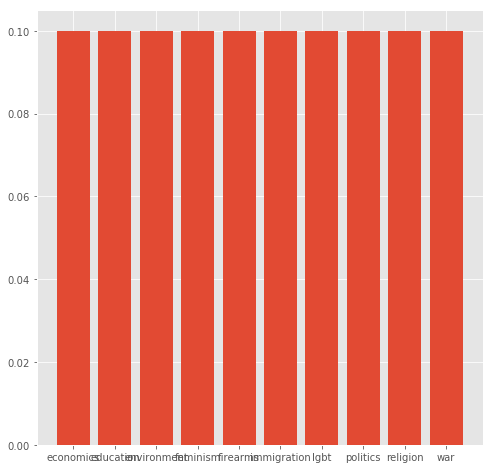

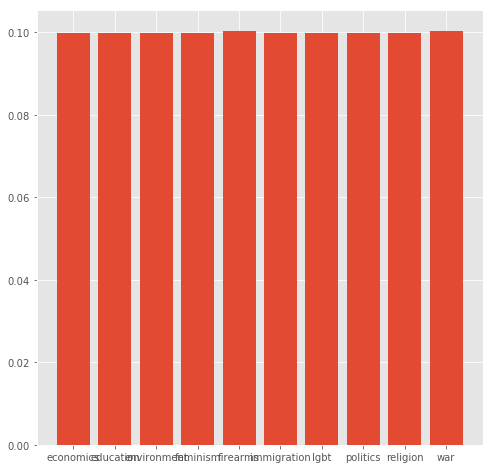

In [35]:
y_train_txt = onehot_enc.inverse_transform(y_train)

c = np.unique(y_train_txt,return_counts=True)

c = np.array(c)

c[1] = c[1]/np.sum(c[1])
plt.figure(figsize=(8,8))
plt.bar(c[0],c[1])
plt.show()

y_train_txt = onehot_enc.inverse_transform(y_val)

c = np.unique(y_train_txt,return_counts=True)

c = np.array(c)

c[1] = c[1]/np.sum(c[1])
plt.figure(figsize=(8,8))
plt.bar(c[0],c[1])
plt.show()

# Model

In [36]:
layers = 2

In [37]:
cells = 32

In [38]:
bi = False

In [39]:
inputs = keras.layers.Input(
    shape=(MAX_LEN, 300,), name='Input')

prev = inputs
for i in range(layers):
    ret_seq = True
    if i == layers-1:
        ret_seq = False

    this_layer = keras.layers.LSTM(
        cells,
        dropout=0.4,
        name='LSTM_%s' %i,
        return_sequences=ret_seq
    )
    if bi:
        this_layer = keras.layers.Bidirectional(
            this_layer,
            name='bi_%s' %i
        )
    prev = this_layer(prev)
    
prev = keras.layers.Dense(
    100,
    activation='relu',
    )(prev)

dense = keras.layers.Dropout(.4)(prev)

dense = keras.layers.Dense(
    len(onehot_enc.categories_[0]), 
    activation='softmax', 
    name="dense_outputs")(prev)

model = keras.Model(inputs=inputs, outputs=[dense])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
loss = 'categorical_crossentropy'
optimizer = keras.optimizers.Adam(lr=0.005)

In [41]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 40, 300)           0         
_________________________________________________________________
LSTM_0 (LSTM)                (None, 40, 32)            42624     
_________________________________________________________________
LSTM_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_outputs (Dense)        (None, 10)                1010      
Total params: 55,254
Trainable params: 55,254
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_dir = "model12_correctsplit"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
callbacks = []

# save model checkpoints
filepath = os.path.join(model_dir,
                'model.h5')

callbacks.append(ModelCheckpoint(filepath,
                         monitor='val_acc',
                         verbose=1,
                         save_best_only=True,
                         save_weights_only=True,
                         mode='auto'))

callbacks.append(ReduceLROnPlateau(monitor='val_acc',
                           factor=0.5,
                           patience=3,
                           verbose=1,
                           mode='auto',
                           epsilon=0.0005,
                           cooldown=0,
                           min_lr=0))
callbacks.append(TQDMNotebookCallback())


c:\anaconda3\envs\tstd\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [60]:
h = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=40,
    verbose=0,
    validation_data=(X_val,y_val),
    callbacks=callbacks
)


Epoch 00001: val_acc improved from -inf to 0.72603, saving model to model12_correctsplit\model.h5



Epoch 00002: val_acc improved from 0.72603 to 0.75429, saving model to model12_correctsplit\model.h5



Epoch 00003: val_acc improved from 0.75429 to 0.78961, saving model to model12_correctsplit\model.h5



Epoch 00004: val_acc improved from 0.78961 to 0.80575, saving model to model12_correctsplit\model.h5



Epoch 00005: val_acc did not improve from 0.80575



Epoch 00006: val_acc did not improve from 0.80575



Epoch 00007: val_acc did not improve from 0.80575

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.



Epoch 00008: val_acc improved from 0.80575 to 0.81130, saving model to model12_correctsplit\model.h5



Epoch 00009: val_acc improved from 0.81130 to 0.81382, saving model to model12_correctsplit\model.h5



Epoch 00010: val_acc did not improve from 0.81382



Epoch 00011: val_acc improved from 0.81382 to 0.81382, saving model to model12_correctsplit\model.h5



Epoch 00012: val_acc did not improve from 0.81382

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.



Epoch 00013: val_acc improved from 0.81382 to 0.81937, saving model to model12_correctsplit\model.h5



Epoch 00014: val_acc did not improve from 0.81937



Epoch 00015: val_acc did not improve from 0.81937



Epoch 00016: val_acc did not improve from 0.81937

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.



Epoch 00017: val_acc improved from 0.81937 to 0.82089, saving model to model12_correctsplit\model.h5



Epoch 00018: val_acc did not improve from 0.82089



Epoch 00019: val_acc did not improve from 0.82089



Epoch 00020: val_acc did not improve from 0.82089

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.



Epoch 00021: val_acc improved from 0.82089 to 0.82190, saving model to model12_correctsplit\model.h5



Epoch 00022: val_acc did not improve from 0.82190



Epoch 00023: val_acc did not improve from 0.82190



Epoch 00024: val_acc improved from 0.82190 to 0.82240, saving model to model12_correctsplit\model.h5



Epoch 00025: val_acc improved from 0.82240 to 0.82341, saving model to model12_correctsplit\model.h5



Epoch 00026: val_acc did not improve from 0.82341



Epoch 00027: val_acc improved from 0.82341 to 0.82543, saving model to model12_correctsplit\model.h5



Epoch 00028: val_acc did not improve from 0.82543



Epoch 00029: val_acc did not improve from 0.82543



Epoch 00030: val_acc did not improve from 0.82543

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.



Epoch 00031: val_acc did not improve from 0.82543



Epoch 00032: val_acc did not improve from 0.82543



Epoch 00033: val_acc did not improve from 0.82543

Epoch 00033: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.



Epoch 00034: val_acc did not improve from 0.82543



Epoch 00035: val_acc did not improve from 0.82543



Epoch 00036: val_acc did not improve from 0.82543

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.



Epoch 00037: val_acc did not improve from 0.82543



Epoch 00038: val_acc did not improve from 0.82543



Epoch 00039: val_acc did not improve from 0.82543

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.



Epoch 00040: val_acc did not improve from 0.82543


In [55]:
filepath

'model12_correctsplit\\model.h5'

In [56]:
model.load_weights(filepath)

Normalized confusion matrix
saving figure to results\conf_matrix.png


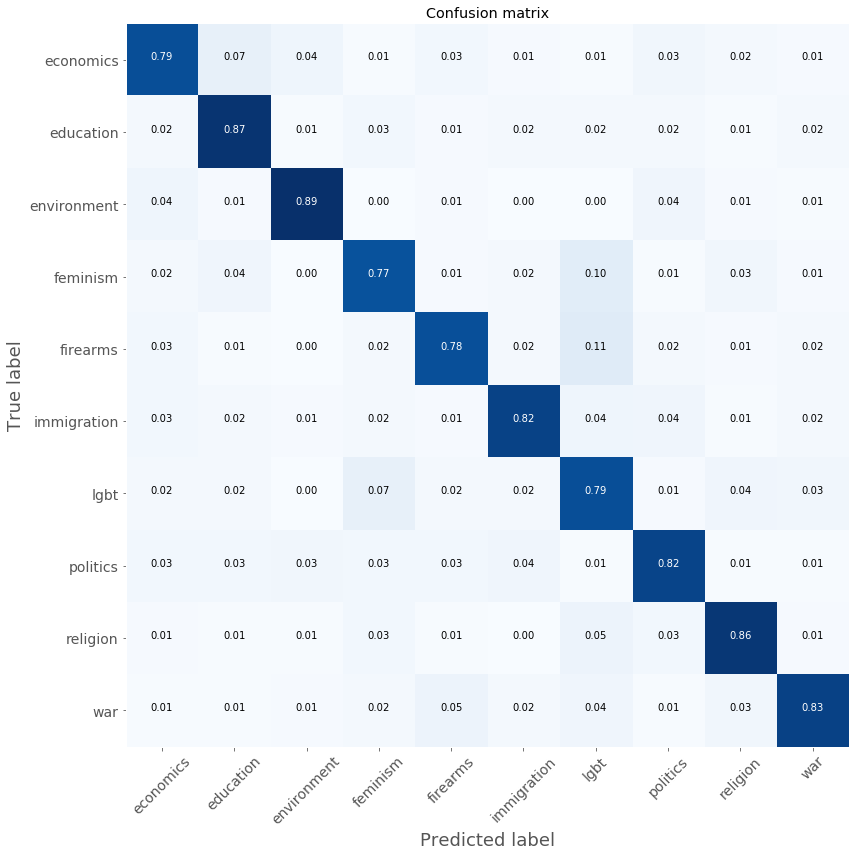

In [50]:
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_argmax = np.argmax(y_val, axis=1)


cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

fig = plot_confusion_matrix(cnf_matrix, onehot_enc.categories_[0], normalize=True)
savefig(fig,'conf_matrix.png')

In [51]:
y_preds = np.argmax(model.predict(X_val),axis=1)

In [52]:
from sklearn.metrics import f1_score, accuracy_score

In [53]:
f1_score(np.argmax(y_val,axis=1), y_preds, average='micro')

0.8229061553985872

In [54]:
plt.figure(figsize=(8,6))
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('training history', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
savefig(plt.gcf(), 'history.png')
plt.show()

NameError: name 'h' is not defined

<Figure size 576x432 with 0 Axes>

# Firearms - lgbt problem

In [116]:
firearms_lgbt = pd.DataFrame(columns=['text','processed','true','predict','confidence','second guess','second guess confidence'])
firearms_df = data[data.category=='firearms']
for i, row in tqdm(firearms_df.iterrows(),total=len(firearms_df)):
    s = row['text']
    s_encoded = preprocess_sentence(s,we,MAX_LEN=40)
    preds = model.predict(np.array([
                s_encoded
            ]))
    second_c, top_c = np.sort(preds)[:,-2:][0]
    second, top = onehot_enc.categories_[0][np.argsort(preds)[:,-2:]][0]
    firearms_lgbt.loc[len(firearms_lgbt)] = [s, row.text_processed, row.category, top, top_c, second, second_c]

In [157]:
[print(s, '\n\n----\n') for s in firearms_lgbt[firearms_lgbt['predict']=='lgbt'].sort_values('confidence', ascending=False).head(10)['text'].values]

yippee ki yay mother fuckers! 

----

I’ll take things that never happened for 500, Alex.( Jen— > UVU
| @ITMFA_NOW

Overheard in my living room where my
daughter and her friend are having a
sleepover: when do you think it will
happen at our school? who do you think
it would be? what would you do? |
would die if you died..| fucking hate this
so much... my heart is so heavy

5/19/18, 6:14 PM

21.7K Retweets 96.7K Likes 

----

Reddit Mods hate this image. 

----

Proud and Beautiful 

----

It’s so cute . I want one for the novelty 

----

A childhood dream of mine has been realized. I am now the proud owner of a 100 double drumrt

|
| 

----

Dad's 50th Bday Present 

----

Whether we are celebrating Christmas with friends and family, or depressingly alone, let us not forget the real reason for the seaaon 

----

Excitement got the best of me! Here she is!!!! July of 1944!!!!!Pe ee ee ee ee 

----

I think we all know what that would be used for if it were in our homes.@

it lane ee 

-

[None, None, None, None, None, None, None, None, None, None]

In [161]:
print(firearms_lgbt[firearms_lgbt['predict']=='lgbt'].sort_values('confidence', ascending=False).head(10))

                                                                                                                                                                                                                                                                                                                                                                                                            text  \
331                                                                                                                                                                                                                                                                                                                                                                                yippee ki yay mother fuckers!   
955  I’ll take things that never happened for 500, Alex.( Jen— > UVU\n| @ITMFA_NOW\n\nOverheard in my living room where my\ndaughter and her friend are having a\nsleepover: when do you think i

In [123]:
errs = []

lgbt_predictions = pd.DataFrame(columns=['text','processed','true','predict','confidence','second guess','second guess confidence'])
lgbt_df = data[data.category=='lgbt']
for i, row in tqdm(lgbt_df.iterrows(),total=len(lgbt_df)):
    s = row['text']
    try:
        s_encoded = preprocess_sentence(s,we,MAX_LEN=40)
        preds = model.predict(np.array([
                    s_encoded
                ]))
        second_c, top_c = np.sort(preds)[:,-2:][0]
        second, top = onehot_enc.categories_[0][np.argsort(preds)[:,-2:]][0]
        lgbt_predictions.loc[len(lgbt_predictions)] = [s, row.text_processed, row.category, top, top_c, second, second_c]
    except Exception as e:
        errs.append(s)

In [126]:
lgbt_predictions[lgbt_predictions.predict=='firearms'].sort_values('confidence',ascending=False)

,text,processed,true,predict,confidence,second guess,second guess confidence
319,"Today marks the second anniversary of the Pulse shooting in Orlando, Florida",today mark second anniversary pulse shoot orlando florida,lgbt,firearms,0.756446,lgbt,0.188461
666,When you can't handle >7 inch dicksCrake,when handle inch dickscrake,lgbt,firearms,0.644878,lgbt,0.207264
761,Add the words Idaho!!!! Massive turnout in Boise. Amazing rainbow day in a normally red only state 😁,add word idaho massive turnout boise amazing rainbow day normally red state,lgbt,firearms,0.561439,lgbt,0.177700
240,"All my stuff got lost when I moved, so I have to rebuild. Of course, the first thing I buy is THE PLAN.(Uae: a |\n\nmotte\n— /",all stuff get lose move rebuild of course thing buy the motte,lgbt,firearms,0.519650,lgbt,0.316173
813,*want to vomit*JAYQ M\n; Oem as\n\nme when i accidentally type in Pornhub.com\ninstead of pornhub.com/gay,want m oem accidentally type instead,lgbt,firearms,0.463744,lgbt,0.377856
930,Can a Traffic Jam be Fierce?[7] Traffic Information [7] -\n\nTS MEA cel)- bale emer\n\nae aaa |\niia |\nTHROUGHOUT city i,can traffic jam traffic information ts mea bale emer ae aaa iia throughout city,lgbt,firearms,0.427132,lgbt,0.346508
961,"yesterday in Nanjing, Chinaa\nm\n\niu\n\n=\n‘=\ng\nfel,\nIS\n-\npa",yesterday nanjing chinaa m iu g fel is pa,lgbt,firearms,0.426423,lgbt,0.346564
210,So happy this subreddit has been banned.,so happy subreddit ban,lgbt,firearms,0.388590,feminism,0.292609
450,"Not mine, just wanted to spread it around.",not want spread,lgbt,firearms,0.368430,lgbt,0.332008
727,Is this right or wrong?,be right wrong,lgbt,firearms,0.303868,lgbt,0.265197


In [127]:
lgbt_predictions[lgbt_predictions['second guess']=='firearms'].sort_values('second guess confidence',ascending=False)

,text,processed,true,predict,confidence,second guess,second guess confidence
948,Got this Apple Watch strap today,get apple watch strap today,lgbt,lgbt,0.433556,firearms,0.426705
488,"Just a reminder, this river actually exists in Finland.7\nAE\n©\n\ntie\n\n; LUNE)\n\n \n\n190\n\n \n\n \n\n \n\n \n\n3003\n\nHakkarin",just reminder river actually exist ae tie lune hakkarin,lgbt,lgbt,0.437695,firearms,0.417708
655,Still happy:)Mo ks\nee,still ks ee,lgbt,lgbt,0.545232,firearms,0.398607
912,Y’all don’t wear socks huhWhen you realize that you forgot\nto wear socks during the 10 hour\nanal session with your homie,wear sock huhwhen realize forget wear sock hour anal session homie,lgbt,lgbt,0.371892,firearms,0.364443
471,WeeeeeeeeAftermonths Ofspain\nandifear I finally wo,weeeeeeeeaftermonths ofspain andifear finally wo,lgbt,lgbt,0.518725,firearms,0.359858
663,"A light gaying is predicted, come prepared!S30 aa Ls\nTe aaa\nie",a light gaying predict come aa ls te aaa ie,lgbt,lgbt,0.599683,firearms,0.342208
668,DogsDOGS ARE\nSO WEIRD\n\n \n\nSKELETONCLAW.COM\n\n@SKELETON-CLAW,dogsdog are so weird claw,lgbt,lgbt,0.419468,firearms,0.329033
574,San Francisco Airport to Rename Terminal After Harvey Milk.,san francisco airport rename terminal after harvey milk,lgbt,economics,0.338228,firearms,0.327749
113,Currently being stood up,currently stand,lgbt,lgbt,0.381421,firearms,0.319087
517,"YupACO Senn Ent]\nee OT) Ea tng 7 P\nre N an less a)\n©, @ibefore you even\nPOA Lah pe Og\nSe kee “ies",yupaco senn ent ee ot ea tng p n poa lah pe og se kee ie,lgbt,lgbt,0.500485,firearms,0.315879


# On the republican and democratic submissions

In [371]:
democrat = open("dump_democrat.txt","r",encoding='utf8').readlines()

In [373]:
df = pd.DataFrame(columns=['text','party','predict','confidence','second guess','second guess confidence'])

In [374]:
for s in tqdm(democrat):
    if len(s.strip()) > 0:
        s_encoded = preprocess_sentence(s,we,MAX_LEN=40)
        preds = model.predict(np.array([
                    s_encoded
                ]))
        second_c, top_c = np.sort(preds)[:,-2:][0]
        second, top = onehot_enc.categories_[0][np.argsort(preds)[:,-2:]][0]
        df.loc[len(df)] = [s, 'democrat', top, top_c, second, second_c]


In [375]:
republican = open("dump_republican.txt","r",encoding='utf8').readlines()

In [376]:
errs = []
for s in tqdm(republican):
    if len(s.strip()) > 0:
        try:
            s_encoded = preprocess_sentence(s,we,MAX_LEN=40)
            preds = model.predict(np.array([
                        s_encoded
                    ]))
            second_c, top_c = np.sort(preds)[:,-2:][0]
            second, top = onehot_enc.categories_[0][np.argsort(preds)[:,-2:]][0]
            df.loc[len(df)] = [s, 'republican', top, top_c, second, second_c]
        except Exception as e:
            errs.append(s)


In [377]:
df.sample(10)

,text,party,predict,confidence,second guess,second guess confidence
579,"Poll: Clinton's lead over Sanders grows: Hillary Clinton's lead in the Democratic presidential primary race has grown -- and if Vice President Joe Biden decides to stay out of the race, her numbers would rise even higher, a new CNN/ORC poll shows. \n",democrat,politics,0.998786,environment,0.000522
168,Bernie Sanders' Stunning Upset Victory in Michigan Means This Race Is Far from Over: Nobody — especially the pollsters — saw this coming \n,democrat,politics,0.982653,economics,0.008139
477,This Bernie Sanders statement on the Nevada convention reads like an open threat to the Democratic establishment \n,democrat,politics,0.995615,firearms,0.001945
1054,"You know how Sarah Palin said Paul Revere warned the British? Well, he did. Now, who looks stupid? - latimes.com \n",republican,religion,0.316804,feminism,0.289775
169,2 winners and 3 losers from Tuesday night's primaries \n,democrat,firearms,0.414072,feminism,0.170455
114,The Bosses \n,democrat,lgbt,0.384850,firearms,0.249844
1428,Reddit's solution to crime \n,republican,war,0.319413,immigration,0.204040
79,The Sanders Campaign Thinks It Can Give Us 5 Percent Economic Growth. It’s Deluded. \n,democrat,economics,0.997897,politics,0.001080
2,"Mitch McConnell Says He Stood Up for Women in a Senate Sexual-Harassment Scandal: The Real Story is Damning - McConnell claims he led a 1995 investigation against a GOP senator accused of sexual misconduct. Actually, he took steps to keep it quiet. \n",democrat,politics,0.662129,feminism,0.332257
1083,CNN calls hero of Florida shooting a liar because he refuses to ask scripted question that pushes gun control narrative. \n,republican,firearms,0.998092,politics,0.001821


In [395]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    s_encoded = _preprocess(row.text)
    df.loc[i, 'text_processed'] = ' '.join(s_encoded)

In [396]:
df.to_csv("13_predictions_df.csv", index=False)

In [398]:
df.sample(10)

,text,party,predict,confidence,second guess,second guess confidence,text_processed
238,What do the Right and Saddam Hussein have in common? Opposition to the freedom to unionize. \n,democrat,firearms,0.407444,feminism,0.242239,what right saddam hussein common opposition freedom unionize
248,American elections ranked worst among Western democracies — here’s why \n,democrat,politics,0.625341,war,0.293674,american election rank worst western democracy
1165,"Barack Obama, the Food Stamp President \n",republican,politics,0.982352,economics,0.010783,barack obama food stamp president
1004,What has caused more damage? \n,republican,war,0.474992,feminism,0.143302,what cause damage
1284,Thank these Republicans for Obamacare \n,republican,politics,0.895139,economics,0.068618,thank republicans obamacare
531,Mainstream Media Gets Schooled On Why Millennial Sanders Supporters Will Vote For Clinton: The media got a taste of reality as they were forced to face the truth that millennial Bernie Sanders supporters care about the issues and will support Hillary Clinton over Donald Trump. \n,democrat,politics,0.998342,education,0.000713,mainstream media get school on why millennial sanders supporters will vote for clinton the medium get taste reality force face truth millennial bernie sanders supporter care issue support hillary clinton donald trump
1839,Alexandria Ocasio-Cortez Bullsh*t Quote Generator \n,republican,politics,0.508143,religion,0.267758,alexandria ocasio cortez quote generator
1824,"Obama abusing power by using IRS, Labor Dept and private goons to publicly call out and harass pro Romney donors. \n",republican,politics,0.982624,economics,0.007502,obama abuse power irs labor dept private goon publicly harass pro romney donor
379,Sanders to DNC: Remove Barney Frank \n,democrat,politics,0.987055,economics,0.004188,sanders dnc remove barney frank
1503,Putin is the one who really deserves that Nobel Peace Prize \n,republican,war,0.860783,politics,0.099879,putin deserve nobel peace prize


# Visualizations

saving figure to results\Democrats_with_politics


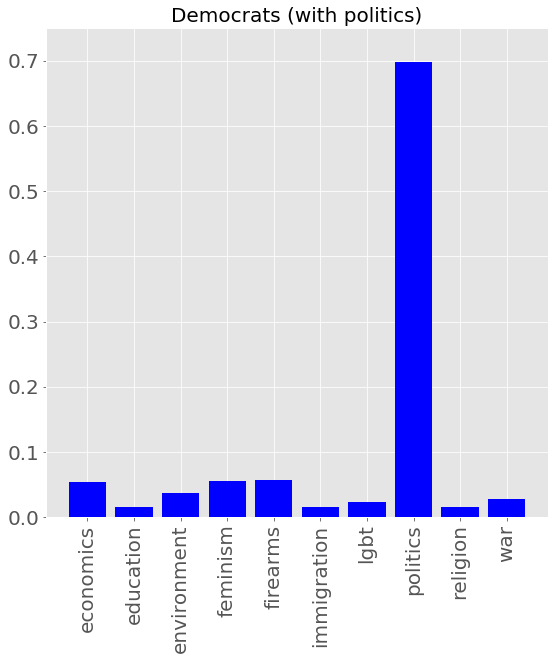

saving figure to results\republicans_with_politics


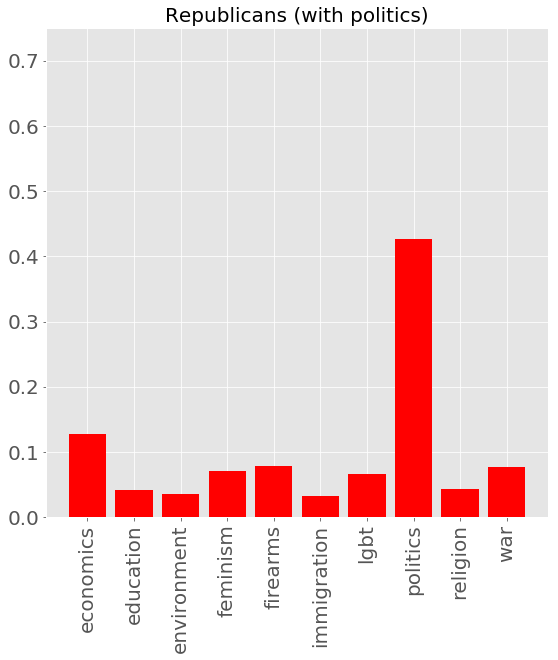

In [378]:
bars = np.unique(df[df['party']=='democrat'].predict.values,return_counts=True)
bars = np.array(bars)
bars[1] = bars[1]/np.sum(bars[1])

plt.figure(figsize=(9,9))
plt.bar(bars[0], bars[1],color='blue')
plt.ylim(0,0.75)
plt.title("Democrats (with politics)", fontsize = 20)
plt.xticks(fontsize = 20, rotation='vertical')
plt.yticks(fontsize=20)

savefig(plt.gcf(), 'Democrats_with_politics')
plt.show()

bars = np.unique(df[df['party']=='republican'].predict.values,return_counts=True)
bars = np.array(bars)
bars[1] = bars[1]/np.sum(bars[1])

plt.figure(figsize=(9,9))
plt.bar(bars[0], bars[1],color='red')
plt.ylim(0,0.75)
plt.title("Republicans (with politics)", fontsize = 20)

plt.xticks(fontsize = 20, rotation='vertical')
plt.yticks(fontsize=20)

savefig(plt.gcf(), 'republicans_with_politics')
plt.show()

saving figure to results\Democrats_without_politics


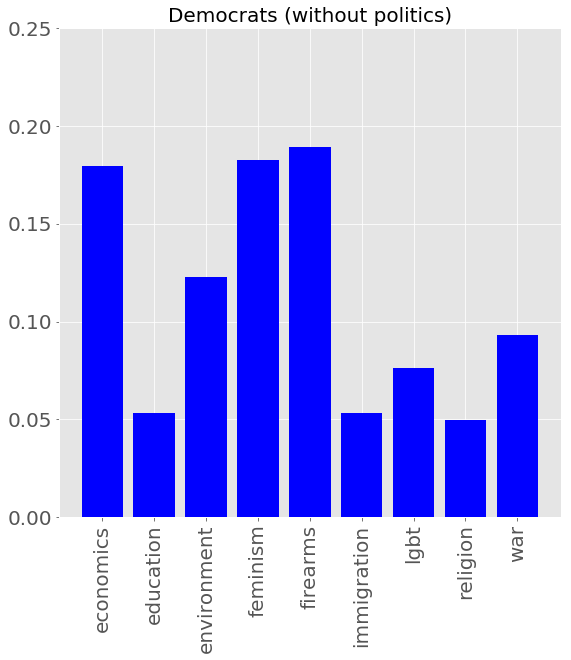

saving figure to results\republicans_without_politics


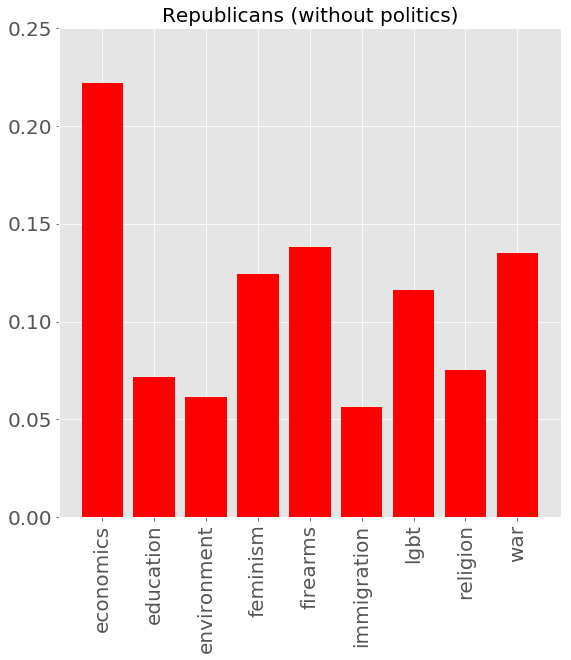

In [380]:
bars = np.unique(df[(df['party']=='democrat') & (df['predict']!='politics')  ].predict.values,return_counts=True)
bars = np.array(bars)
bars[1] = bars[1]/np.sum(bars[1])

plt.figure(figsize=(9,9))
plt.bar(bars[0], bars[1],color='blue')
plt.ylim(0,0.25)
plt.title("Democrats (without politics)", fontsize = 20)
plt.xticks(fontsize = 20, rotation='vertical')
plt.yticks(fontsize=20)
savefig(plt.gcf(), 'Democrats_without_politics')
plt.show()

bars = np.unique(df[(df['party']=='republican') & (df['predict']!='politics')  ].predict.values,return_counts=True)
bars = np.array(bars)
bars[1] = bars[1]/np.sum(bars[1])

plt.figure(figsize=(9,9))
plt.bar(bars[0], bars[1],color='red')
plt.ylim(0,0.25)
plt.title("Republicans (without politics)", fontsize = 20)
plt.xticks(fontsize = 20, rotation='vertical')
plt.yticks(fontsize=20)
savefig(plt.gcf(), 'republicans_without_politics')
plt.show()

# Avg confidence

In [389]:
topics = np.unique(df[(df['predict']!='politics')].predict)

columns = []
for t in topics:
    columns.append(t)

confidence_df = pd.DataFrame(columns=['republican','republican counts', 'democrat', 'democrat counts'], index=columns)

topics = np.unique(df[(df['predict']!='politics')].predict)
for t in topics:
    print(t)
    for p in ['democrat','republican']:
        selection = df[(df.predict==t) & (df.party==p)].confidence
#         confidence_df.loc['%s mean' %t, p] = selection.mean()
#         confidence_df.loc['%s std' %t, p] = selection.std()
        confidence_df.loc[t, '%s counts' %p] = len(selection)
        confidence_df.loc[t, p] = '%.3f' %(selection.mean())

confidence_df

In [89]:
print(confidence_df.to_latex())

\begin{tabular}{lllll}
\toprule
{} & republican & republican counts & democrat & democrat counts \\
\midrule
economics   &      0.783 &               130 &    0.742 &              54 \\
education   &      0.786 &                42 &    0.870 &              16 \\
environment &      0.856 &                36 &    0.854 &              37 \\
feminism    &      0.640 &                73 &    0.778 &              55 \\
firearms    &      0.668 &                81 &    0.678 &              57 \\
immigration &      0.745 &                33 &    0.727 &              16 \\
lgbt        &      0.522 &                68 &    0.603 &              23 \\
religion    &      0.748 &                44 &    0.755 &              15 \\
war         &      0.699 &                79 &    0.703 &              28 \\
\bottomrule
\end{tabular}



# Print examples with confidences

In [91]:
categories = np.unique(data.category)

In [92]:
for c in categories:
    print('Category: %s' %c.upper())
    c_df = df[df.predict==c].sort_values('confidence',ascending=False)
    print('Top 5 most confident predictions for this')
    print(c_df.head(5))
    with open(os.path.join('results',"%s_top.html" %c), "w") as f:
        f.write(c_df.head(5).to_html())
    print()
    print('5 least confident predictions for this')
    print(c_df.tail(5))
    with open(os.path.join('results',"%s_bottom.html" %c), "w") as f:
        f.write(c_df.tail(5).to_html())
    
    print('='*30)

Category: ECONOMICS
Top 5 most confident predictions for this
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  \
1327    How will raising taxes on the rich and wealthy hurt the economy? So it seems the end of the Bush tax cuts on the wealthy 

516     democrat  education    0.997956    economics                 0.000654  

5 least confident predictions for this
                                                                                   text  \
1760                                                 If I Wanted America to Fail.... \n   
1208                                                     If I wanted America to fail \n   
1603                          In Case You Forgot: The WORST Answer In Debate History \n   
1376                                  Top 10 Reasons Why Obama Won't Win in the Fall \n   
1222    THIS IS EPIC: Bill Whittle explains the REAL HISTORY of the Democratic Party \n   

           party    predict  confidence second guess  second guess confidence  
1760  republican  education    0.368596    economics                 0.203792  
1208  republican  education    0.368596    economics                 0.203792  
1603  republican  education    0.364413          war                 0.148308  
1376  republi

34      democrat  feminism    0.997223     religion                 0.001124  

5 least confident predictions for this
                                                                                            text  \
1205                                                     Sharp analysis of campaign 2012 [FB] \n   
1028                  Dear CNN, Harassing People And Silencing Parkland Survivors Is Not Okay \n   
1831    My friends and I made a song dedicated to Steven Crowder, let us know what you think! \n   
1833                                  Why Pro-life Advocates Should Reject The "Right To Die" \n   
1128                                                        CONSERVATISM IS CALLING - YouTube \n   

           party   predict  confidence second guess  second guess confidence  
1205  republican  feminism    0.273871          war                 0.259934  
1028  republican  feminism    0.250727  environment                 0.201862  
1831  republican  feminism    0.250537     

1520  republican    lgbt    0.987366     religion                 0.005432  

5 least confident predictions for this
                                                                                 text  \
1041                                               Why Kavanaugh must be confirmed \n   
1167    [Suggestion] If you are thinking about seeing 2016, I HIGHLY recommend it. \n   
1855     The Left Has Two Huge Advantages, and I Have No Idea How we Overcome Them \n   
1057                      /r/politics really showed its understanding side today.  \n   
1524                                                One More Week to "Investigate" \n   

           party predict  confidence second guess  second guess confidence  
1041  republican    lgbt    0.297275          war                 0.200354  
1167  republican    lgbt    0.293950          war                 0.168012  
1855  republican    lgbt    0.289931          war                 0.188863  
1057  republican    lgbt    0.267616    

1040  republican     war    0.996112     politics                 0.001270  

5 least confident predictions for this
                                                                                                  text  \
1562                                    President Bush's Scottish terrier dog Barney dies at age 12 \n   
549                           Wall Street Veteran Asher Edelman Explains Why He's Supporting Bernie \n   
1671                                                           24 Pieces of MSM Fake News in 5 Days \n   
975                                                                         Hillary's turning point \n   
331     Americans Don't Know What ‘Single Payer’ Means: And when they find out, they don’t like it. \n   

           party predict  confidence second guess  second guess confidence  
1562  republican     war    0.279798     religion                 0.235983  
549     democrat     war    0.260638    economics                 0.248344  
1671  republica

# Baselines of LDA, HDP, LSI

In [399]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import pickle
import gensim
from gensim.corpora import Dictionary


In [400]:
texts = [str(s).split() for s in df.text_processed]

In [401]:
bigram = gensim.models.Phrases(texts)
texts = [bigram[line] for line in texts]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [402]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [403]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [404]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [405]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [406]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [407]:
model_topics = []
topics = np.unique(df.predict)
for t in topics:
    words_topic = [s.split(" ") for s in df[df.predict==t].text_processed]
    np.random.shuffle(words_topic)
    words_topic = np.unique(np.concatenate(words_topic))
    model_topics.append(words_topic.tolist()[:10])

In [408]:
model_coh = CoherenceModel(topics=model_topics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

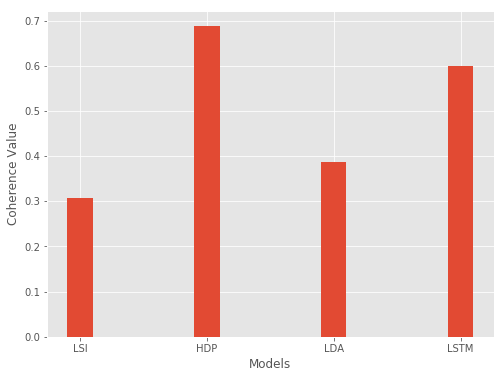

In [409]:
plt.figure(figsize=(8,6))
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, model_coh],
                   ['LSI', 'HDP', 'LDA', 'LSTM'])